In [1]:
# ==========
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from lightning.pytorch import Trainer, seed_everything
from joblib import Parallel, delayed
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pathlib import Path

from src.models.cebra_factorvae_mlp import CEBRAFactorReg
from src.data.spike_datamodule import _SpikePairDataset
from preprocessing.prp import add_perceived_probs
from experiments.GradCAM1D import GradCAM1D
from experiments.PerNeuronImportance import PerNeuronImpartanceCEBRAFactorReg
from derivative import Kalman
from Dynamic_SINDy.timeVAE.utils2 import compute_derivative, library_size, sindy_library

c:\Users\qf1824\.local\share\mamba\envs\my_msc_proj\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\qf1824\.local\share\mamba\envs\my_msc_proj\lib\site-packages\cebra\integrations\sklearn\cebra.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Load data and validate on held-out part of the data

In [2]:

# 64 new
# ckpt_path = 'D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_06_26/505926952829715205/f87cb26d029144bebb64ceb5ba5f668d/checkpoints/epoch=84-step=510.ckpt'

# 16 new
ckpt_path = 'D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_07_01/664223543704393700/f57ea90a7a7e42d48277c3450cf94c63/checkpoints/epoch=65-step=396.ckpt'
# 16 old
# ckpt_path = 'D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_06_26/505926952829715205/c4fdbd091a954de6af1c6a160ea6a791/checkpoints/epoch=43-step=220.ckpt'
# ckpt_path = 'D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_06_26/505926952829715205/c4fdbd091a954de6af1c6a160ea6a791/checkpoints/epoch=41-step=210.ckpt'

session = 'data/processed/spikes.npz'
prpd = 'data/processed/prpd.npz'


spikes = np.load(session)['arr_0']
prpd = np.load(prpd)['arr_0']
prpd[1:] = prpd[:-1]

full_ds = _SpikePairDataset(spikes, prpd, contrastive=True)
loader = DataLoader(full_ds, batch_size=prpd.shape[0], shuffle=False, num_workers=0)

model = CEBRAFactorReg.load_from_checkpoint(ckpt_path, map_location='cuda:0')
model.eval()

trainer = Trainer(accelerator='gpu', devices=1, logger=False, enable_checkpointing=False, max_epochs=1)
metrics = trainer.validate(model, dataloaders=loader, verbose=False)[0]

for k, v in metrics.items():
    print(f'{k}: {v:.4f}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]
val/loss/info_nce: 1.7100
val/loss/tc: 0.0182
val/loss/recon_mse: 0.0002
val/loss/total: 1.7282
val/loss/prpd_mse: 0.0766
val/prpd_r2: 0.7297


Encode latents for the trial-aligned spike array

In [3]:
seed_everything(42)
model.to('cuda')

spike_tensor = torch.as_tensor(spikes, dtype=torch.float32)
dataset = TensorDataset(spike_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

all_latents = []
with torch.no_grad():
    for (x,) in loader:
        x = x.to('cuda').transpose(1, 2)
        z = model.model.encode(x)
        all_latents.append(z.cpu())

latents = torch.cat(all_latents).numpy()
print(latents.shape)

Seed set to 42


(241, 16)


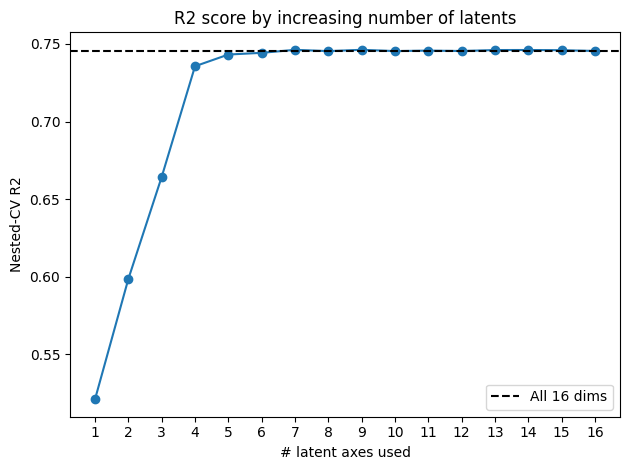

In [4]:
sort_idx = [ 8,  3, 12, 13, 15,  4,  5,  6, 14, 10,  1, 11,  0,  2,  9,  7]
Z = latents[:,sort_idx]
selected, inc_r2 = [], []
residual = prpd.copy()
cv = KFold(n_splits=10, shuffle=True, random_state=0)

for _ in range(Z.shape[1]):
    best_dim, best_r2 = None, -np.inf
    for k in range(Z.shape[1]):
        if k in selected: continue
        X = Z[:, [*selected, k]]
        r2_k = cross_val_score(Ridge(1.0), X, prpd, cv=cv, scoring='r2').mean()
        if r2_k > best_r2:
            best_dim, best_r2 = k, r2_k
    selected.append(best_dim)
    inc_r2.append(best_r2)

k = np.arange(1, len(inc_r2)+1)

plt.plot(k, inc_r2, marker='o')
plt.axhline(inc_r2[-1], color='k', ls='--', label='All 16 dims')
plt.xlabel('# latent axes used')
plt.ylabel('Nested-CV R2')
plt.title('R2 score by increasing number of latents')
plt.xticks(k)
plt.legend()
plt.tight_layout()
plt.show()

Load behav data

In [5]:
droot = Path('C:/Users/qf1824/Desktop/coding/Arseniis_Msc_proj/data/JPAS_0023_20230922')
bp = droot/'BEHAV'

with open(bp/'metrics.json') as f:
    behav = json.load(f)
metrics = behav['metrics']
trials = pd.DataFrame(metrics['trials'])

INIT_PRP = 0.5
trials = add_perceived_probs(trials, init_p=INIT_PRP)

dp = droot/'PHY_AK/uploaded_folder/JPAS_0023_20230922'
spike_clusters = np.load(dp/'spike_clusters.npy')
spike_times = np.load(dp/'spike_times_milliseconds_sync_to_behav.npy')
clust_qa = pd.read_csv(dp/'cluster_group.tsv', sep='\t')
good_unit_id = clust_qa[clust_qa.group == 'good'].cluster_id.tolist()
good_units_mask = np.isin(spike_clusters, good_unit_id)

good_units = spike_clusters[good_units_mask]
good_times = spike_times[good_units_mask]
spike_df = pd.DataFrame({'unit': good_units, 'time_ms': good_times})

Process entire session into firing rate windows

In [6]:
BEHAV_LAG_MS = 200
WIN = 800
WIN_STEP = 400
BIN_MS = 10
normalizer = 5

units = np.sort(spike_df['unit'].unique())
unit2col = {u: i for i, u in enumerate(units)}
T = WIN // BIN_MS
n_units = len(units)

t_start = spike_df.time_ms.values[0]
t_end = spike_df.time_ms.values[-1]
n_windows = int((t_end - t_start - WIN) // WIN_STEP + 1)

spike_tensor = np.zeros((n_windows, T, n_units), dtype=np.uint8)

times = []
latents = []
i = 0

while (t_start + WIN) < t_end:
    t_start_ms = t_start - BEHAV_LAG_MS
    t_end_ms = t_start + WIN - BEHAV_LAG_MS
    t = t_start + (WIN/2)
    times.append(t)
    m = (spike_df.time_ms.values >= t_start_ms) & (spike_df.time_ms.values < t_end_ms)
    sub = spike_df.loc[m]

    if sub.empty:
        continue

    bin_idx = ((sub.time_ms.values - t_start_ms) // BIN_MS).astype(np.int64)
    unit_idx = sub.unit.map(unit2col).values.astype(np.int64)
    np.add.at(spike_tensor, (i, bin_idx, unit_idx), 1)

    i += 1
    t_start += WIN_STEP

spike_tensor = spike_tensor.astype(np.float32)/normalizer
times = np.array(times)


Compute latents for entire session

In [7]:
with torch.no_grad():
    x = torch.from_numpy(spike_tensor).to('cuda').transpose(1, 2)
    model.to('cuda')
    z = model.model.encode(x)
    latents = z.cpu().numpy()

trls = trials[~trials['set reward probabs l/r'].isna()].copy()[:latents.shape[0]].reset_index()
trls['t_min'] = trls['t chosen']/(1000 * 60)
t_min_latents = times/(1000 * 60)
trls = trls[trls.t_min <= (t_min_latents[-1])]

Smooth latents, align them to reward probability and prpd, plot them.

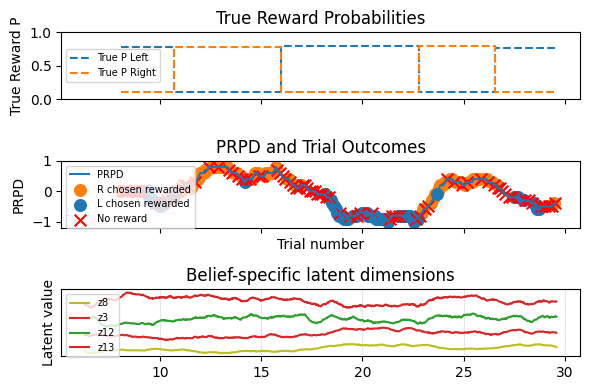

In [8]:
plt.close()
selected_idx = [8,  3, 12, 13]
true_prob = np.array(trls['set reward probabs l/r'].tolist())
trls['true_pL'], trls['true_pR'] = true_prob[:, 0], true_prob[:, 1]

fig, (true_p_ax, prpd_ax, ax_z) = plt.subplots(nrows=3, figsize=(6, 4), sharex=True)

true_p_ax.step(trls.t_min, trls['true_pL'], linestyle='--', where='mid', c='#1f77b4', label='True P Left')
true_p_ax.step(trls.t_min, trls['true_pR'], linestyle='--', where='mid', c='#ff7f0e', label='True P Right')
true_p_ax.set_ylabel('True Reward P')
true_p_ax.set_ylim(0, 1)
true_p_ax.legend(fontsize=7)

right = trls['choice'].str.lower().eq('r')
left = trls['choice'].str.lower().eq('l')

prpd_ax.plot(trls.t_min, trls['PRPD'], label='PRPD')
prpd_ax.scatter(trls.t_min[right & trls['rewarded']],
                trls.loc[right & trls['rewarded'], 'PRPD'],
                marker='o', s=70, c='#ff7f0e', label='R chosen rewarded')
prpd_ax.scatter(trls.t_min[left & trls['rewarded']],
                trls.loc[left & trls['rewarded'], 'PRPD'],
                marker='o', s=70, c='#1f77b4', label='L chosen rewarded')
prpd_ax.scatter(trls.t_min[~trls['rewarded']],
                trls.loc[~trls['rewarded'], 'PRPD'],
                marker='x', s=70, c='red', label='No reward')

color_cycle = plt.cm.tab10.colors

for i, id in enumerate(selected_idx):
    # smoothing
    smooth_latent = np.convolve(latents[:, id], np.ones(80)/80, mode='same')
    ax_z.plot(t_min_latents,
              smooth_latent + i/2,
              label=f'z{id}', color=color_cycle[id % 10])

ax_z.set_ylabel('Latent value')
ax_z.set_yticks([])
ax_z.set_title('Belief-specific latent dimensions')
ax_z.grid(alpha=0.3)
ax_z.legend(fontsize=7, loc='upper left')

prpd_ax.set_xlabel('Trial number')
prpd_ax.set_ylabel('PRPD')
true_p_ax.set_title('True Reward Probabilities')
prpd_ax.set_title('PRPD and Trial Outcomes')
prpd_ax.legend(fontsize=7, loc='upper left')
prpd_ax.set_ylim(-1.2, 1)

plt.tight_layout()
plt.show()

GradCAM to PRPD over Encoder's conv layer

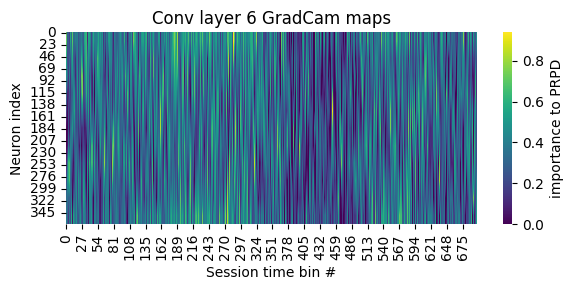

In [9]:
model.eval()
conv_layer = model.model.encoder.net[6]
gradcam = GradCAM1D(model, conv_layer)

x = torch.from_numpy(spike_tensor).to('cuda').transpose(1, 2)
cams, preds = gradcam(x)

zero_threshold = 0.2
neg_idx = preds < -zero_threshold
zero_idx = (preds >= -zero_threshold) & (preds <= zero_threshold)
pos_idx = preds > zero_threshold

cam_neg = cams[neg_idx].mean(0).cpu().numpy()
cam_zero = cams[zero_idx].mean(0).cpu().numpy()
cam_pos = cams[pos_idx].mean(0).cpu().numpy()
cams_abs = cams.mean(0).cpu().numpy()
cams_np = cams.cpu().numpy()

step = 5
T, D = cams.shape
rem = T % step
if rem:
    pad = step - rem
    last = cams[-1:].expand(pad, -1)
    cams_cat = torch.cat([cams, last], dim=0)
    T += pad
else:
    cams_cat = cams

cams_ds = cams_cat.view(T // step, step, D).mean(dim=1)

plt.figure(figsize=(6, 3))
sns.heatmap(cams_ds.cpu().numpy().T, cmap='viridis', cbar_kws={'label': 'importance to PRPD'})
plt.title('Conv layer 6 GradCam maps')
plt.xlabel('Session time bin #')
plt.ylabel('Neuron index')
plt.tight_layout()
plt.show()

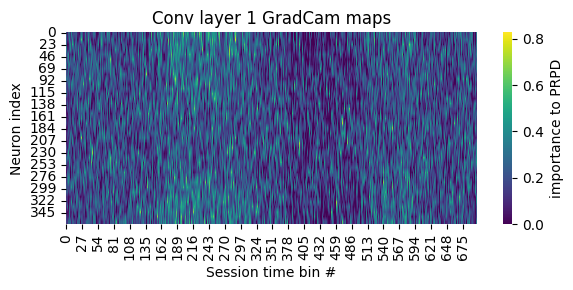

In [10]:
conv_layer = model.model.encoder.net[0].layer
gradcam = GradCAM1D(model, conv_layer)
x = torch.from_numpy(spike_tensor).to('cuda').transpose(1, 2)
cams, preds = gradcam(x)

zero_threshold = 0.2
neg_idx = preds < -zero_threshold
zero_idx = (preds >= -zero_threshold) & (preds <= zero_threshold)
pos_idx = preds > zero_threshold

cam_neg = cams[neg_idx].mean(0).cpu().numpy()
cam_zero = cams[zero_idx].mean(0).cpu().numpy()
cam_pos = cams[pos_idx].mean(0).cpu().numpy()
cams_abs = cams.mean(0).cpu().numpy()
cams_np = cams.cpu().numpy()

step = 5
T, D = cams.shape
rem = T % step
if rem:
    pad = step - rem
    last = cams[-1:].expand(pad, -1)
    cams_cat = torch.cat([cams, last], dim=0)
    T += pad
else:
    cams_cat = cams

cams_ds = cams_cat.view(T // step, step, D).mean(dim=1)

plt.figure(figsize=(6, 3))
sns.heatmap(cams_ds.cpu().numpy().T, cmap='viridis', cbar_kws={'label': 'importance to PRPD'})
plt.title('Conv layer 1 GradCam maps')
plt.xlabel('Session time bin #')
plt.ylabel('Neuron index')
plt.tight_layout()
plt.show()

Compute Vanila saliency maps

In [11]:
model.eval()
per_n_gradcam = PerNeuronImpartanceCEBRAFactorReg(model)

x = torch.from_numpy(spike_tensor).to('cuda').transpose(1, 2)
neuron_cams, preds = per_n_gradcam(x)


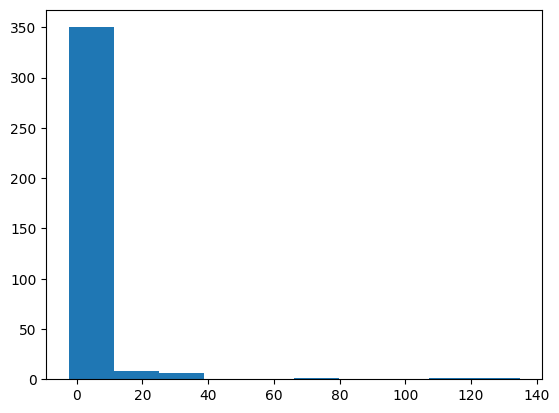

In [12]:
neuron_cams_numpy = neuron_cams.cpu().numpy()
percentile = 99
saliency_thresholded = neuron_cams_numpy.copy()
threshold = np.percentile(neuron_cams_numpy, percentile, axis=(1, 2))
threshold = np.ones(neuron_cams_numpy.shape) * threshold.reshape((-1, 1, 1))
saliency_thresholded[saliency_thresholded < threshold] = 0

neuron_activity = saliency_thresholded.sum(axis=(0, 2))
topk = 100
most_active_indices = np.argsort(-neuron_activity)

shuffled = np.random.permutation(saliency_thresholded.reshape(-1, saliency_thresholded.shape[1])).reshape(saliency_thresholded.shape)
shuffled_activity = np.sum(shuffled, axis=(0, 2))

z_scores = (neuron_activity - shuffled_activity.mean())/(shuffled_activity.std() + 1e-6)

plt.hist(z_scores)
plt.show()

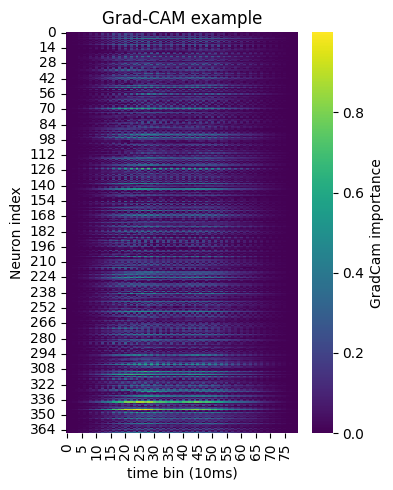

In [13]:
z_scored = np.argwhere(z_scores > 2).reshape(-1)

plt.figure(figsize=(4, 5))
sns.heatmap(neuron_cams.cpu().numpy()[4], cmap='viridis', cbar_kws={'label': 'GradCam importance'})
plt.title('Grad-CAM example')
plt.xlabel('time bin (10ms)')
plt.ylabel('Neuron index')
plt.tight_layout()
plt.show()

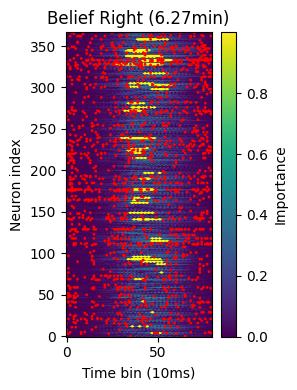

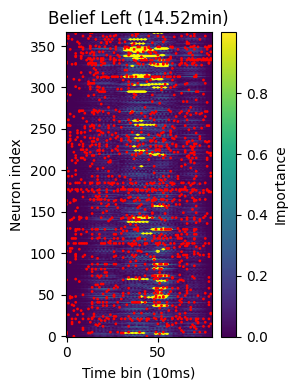

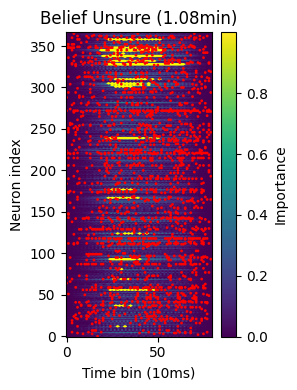

In [14]:
max_idx = np.argmax(preds.cpu().numpy())
min_idx = np.argmin(preds.cpu().numpy())
mid_idx = np.argmin(np.abs(preds.cpu().numpy()))

for window_n, prpd_val in [[max_idx, 'Belief Right'], [min_idx, 'Belief Left'], [mid_idx, 'Belief Unsure']]:
    saliency = neuron_cams.cpu().numpy()[window_n].T
    spikes = spike_tensor[window_n]
    percentile = 99
    threshold = np.percentile(saliency, percentile)
    saliency_thresh = saliency.copy()
    saliency_thresh[saliency_thresh < threshold] = 0

    fig, ax = plt.subplots(figsize=(3, 4))
    im = ax.imshow(saliency.T, aspect='auto', origin='lower', cmap='viridis', zorder=0)
    ax.contour(saliency_thresh.T, levels=5, colors='yellow', linewidths=0.5, zorder=1)

    ax.set_ylabel('Neuron index')
    ax.set_xlabel('Time bin (10ms)')
    ax.set_title(f'{prpd_val} ({window_n*(0.4/60):.2f}min)')
    plt.colorbar(im, ax=ax, label='Importance')

    ys, xs = np.where(spikes.T > 0)
    ax.scatter(xs, ys, s=4, c='red', marker='o', edgecolors='none', zorder=2)

    plt.tight_layout()
    plt.show()

PRPD prediction over entire session

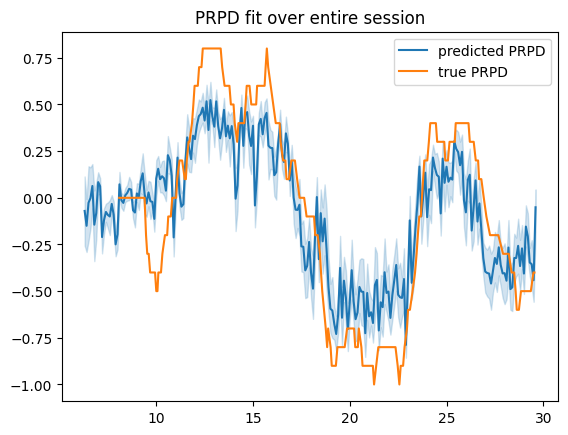

In [15]:

sns.lineplot(x=t_min_latents.round(1), y=preds.cpu().numpy(), label='predicted PRPD')
plt.plot(trls.t_min, trls['PRPD'], label='true PRPD')
plt.legend()
plt.title('PRPD fit over entire session')
plt.show()